In [56]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm, boxcox
from scipy import stats
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import pickle as pk

In [57]:
data = pd.read_csv('/Users/sahithiuthpalamateti/Downloads/used_device_data.csv')

In [58]:
data.head()

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


In [59]:
data .shape

(3454, 15)

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   rear_camera_mp         3275 non-null   float64
 6   front_camera_mp        3452 non-null   float64
 7   internal_memory        3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

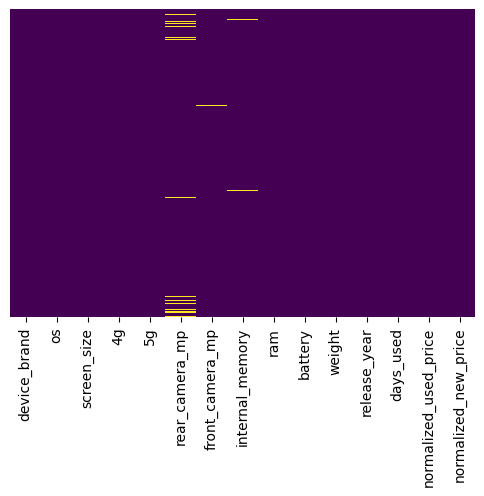

In [61]:
# Checking Null values
plt.figure(figsize=(6, 4))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

In [62]:
data=data.dropna()

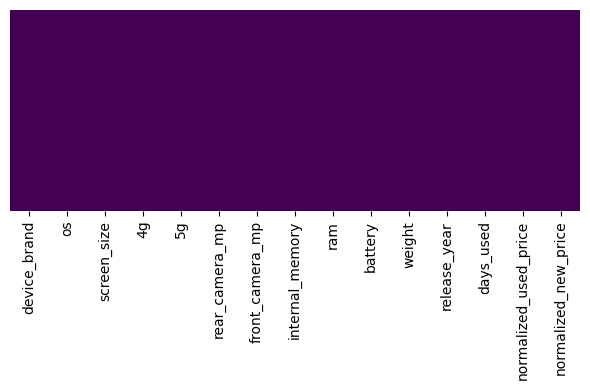

In [63]:
plt.figure(figsize=(6, 4)) 
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.tight_layout()
plt.show()

In [64]:
data.nunique()

device_brand               33
os                          4
screen_size               135
4g                          2
5g                          2
rear_camera_mp             41
front_camera_mp            36
internal_memory            15
ram                        12
battery                   314
weight                    542
release_year                8
days_used                 878
normalized_used_price    2921
normalized_new_price     2845
dtype: int64

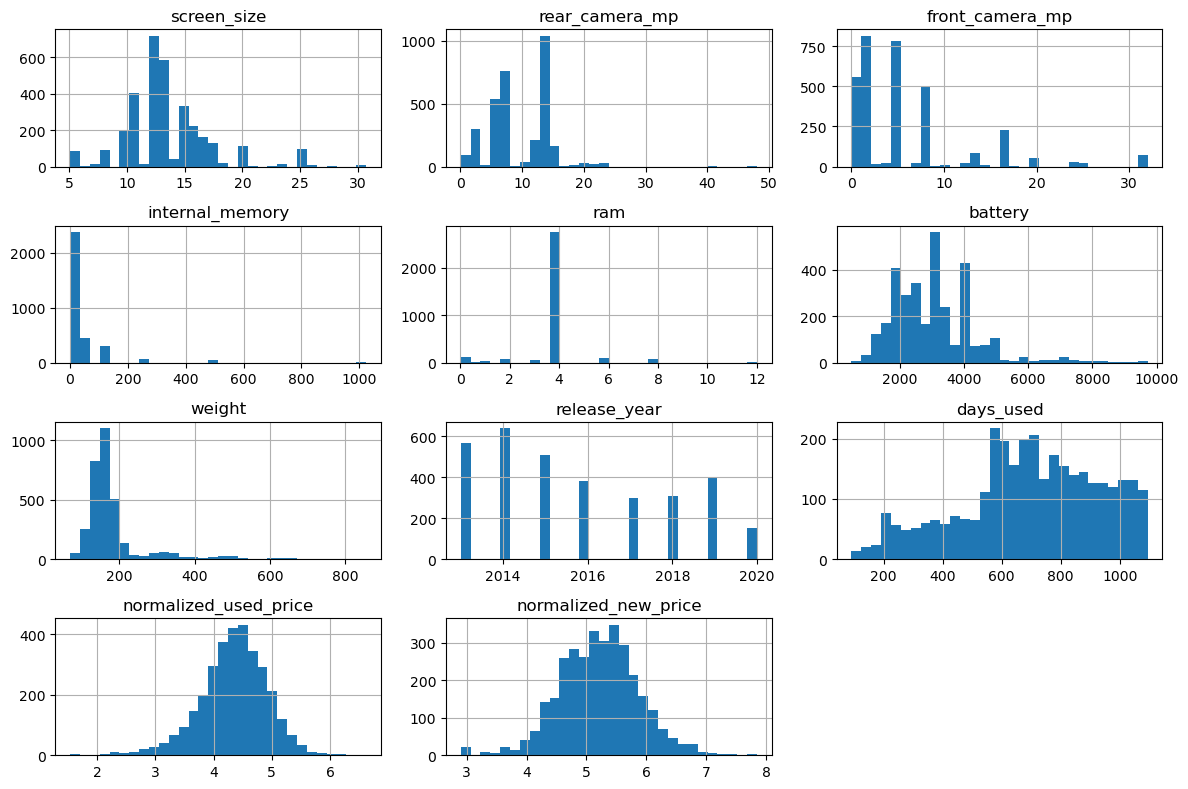

In [65]:
#Checking distribution of the datset
data.hist(figsize=(12,8),bins=30)
plt.tight_layout()
plt.show()

In [66]:
#Converting Categorical to binary categorical
data["4g"] = data["4g"].replace(["yes","no"],[1,0])
data["5g"] = data["5g"].replace(["yes","no"],[1,0])
data.head()

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,1,0,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,1,1,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,1,1,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,1,1,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,1,0,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


In [67]:
data.columns
cols2=['screen_size','rear_camera_mp','front_camera_mp','battery','weight','days_used',
'normalized_new_price','normalized_used_price']

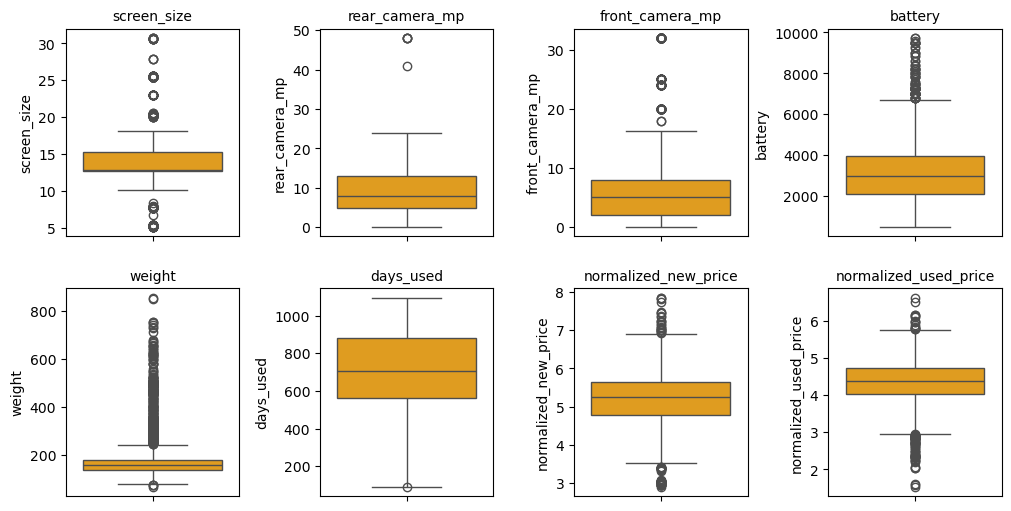

In [68]:
#Checking outliers
fig, ax = plt.subplots(2, 4, figsize=(10, 5))  # smaller width & height
ax = ax.flatten()

for index, col in enumerate(cols2):
    sns.boxplot(y=col, data=data, color='orange', ax=ax[index])
    ax[index].set_title(col, fontsize=10)  # optional: smaller title font

plt.tight_layout(pad=0.3, w_pad=0.5, h_pad=2.0)  # tighter layout
plt.show()

In [69]:
def detect_outliers(columns):
    outlier_indices = []

    for column in columns:
        Q1 = np.percentile(data[column], 25)
        Q3 = np.percentile(data[column], 75)
        IQR = Q3 - Q1
        outlier_step = IQR * 1.5

        outlier_list_col = data[
            (data[column] < Q1 - outlier_step) |
            (data[column] > Q3 + outlier_step)
        ].index

        outlier_indices.extend(outlier_list_col)

    return outlier_indices

In [70]:
data = data.drop(detect_outliers(cols2),axis = 0).reset_index(drop = True)
data.shape[0]

2480

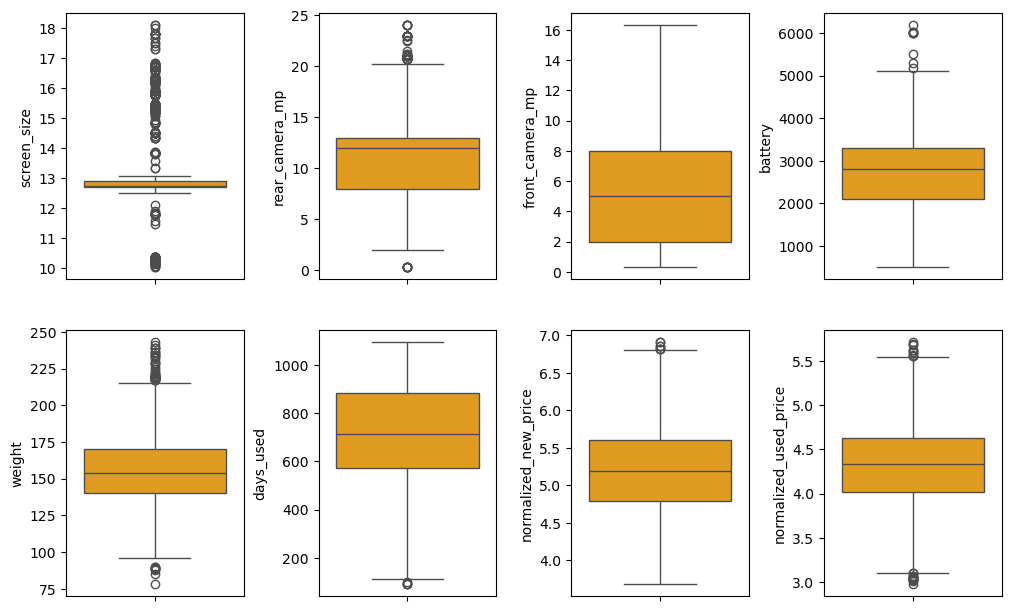

In [71]:
fig, ax = plt.subplots(2, 4, figsize=(10, 6))  # smaller size
ax = ax.flatten()

for i, col in enumerate(cols2):
    sns.boxplot(y=data[col], color='orange', ax=ax[i])

plt.tight_layout(pad=0.3, w_pad=0.7, h_pad=3)
plt.show()

In [72]:
#Function to apply different transformation on variables to get normalized data
def try_transformation(column, method):
    try:
        print(f"{method.capitalize()} - {column}")
        if method == 'boxcox':
            temp, _ = boxcox(data[column] + 1)
        elif method == 'log':
            temp = np.log1p(data[column])
        elif method == 'reciprocal':
            temp = 1 / data[column].replace(0, np.nan)
            temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            temp.dropna(inplace=True)
        elif method == 'sqroot':
            temp = np.sqrt(data[column])
        elif method == 'exp':
            temp = data[column]**(1/1.2)
        else:
            print("Invalid method"); return

        mu, sigma = norm.fit(temp)
        print(f"mu: {mu:.2f}, sigma: {sigma:.2f}")

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        sns.histplot(temp, kde=True, color="orange")
        plt.title(f"{method.capitalize()} - Distplot")

        plt.subplot(1, 2, 2)
        stats.probplot(temp, dist="norm", plot=plt)
        plt.title(f"{method.capitalize()} - QQ Plot")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error with {method} on {column}: {e}")

transformations = ['boxcox', 'log', 'reciprocal', 'sqroot', 'exp']

Boxcox - screen_size
mu: 2.54, sigma: 0.13


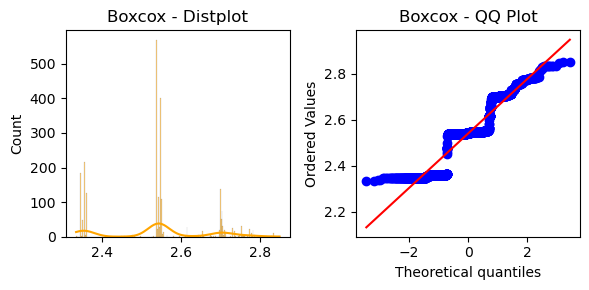

Log - screen_size
mu: 2.62, sigma: 0.13


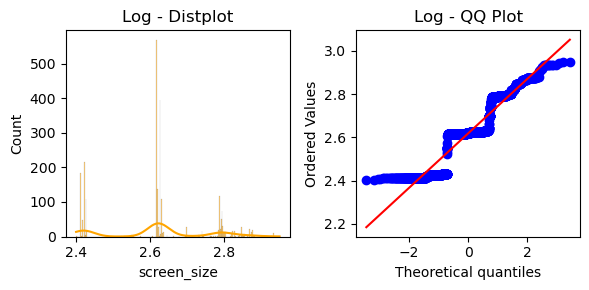

Reciprocal - screen_size
mu: 0.08, sigma: 0.01


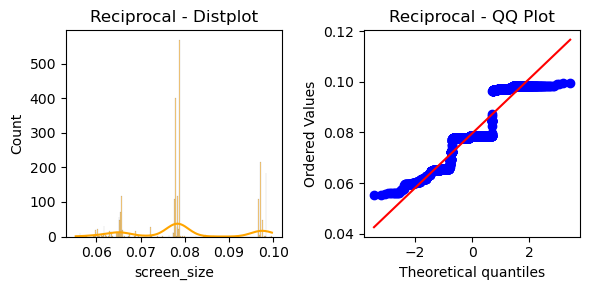

Sqroot - screen_size
mu: 3.57, sigma: 0.26


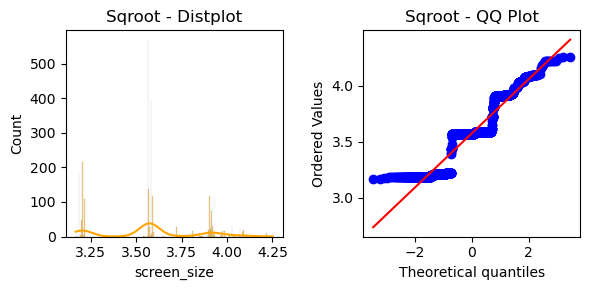

Exp - screen_size
mu: 8.37, sigma: 1.01


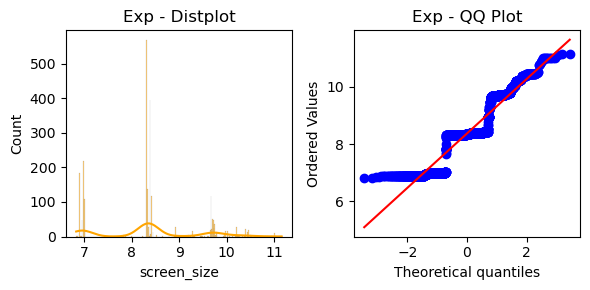

In [73]:
for x in transformations:
   try_transformation('screen_size',x)

Boxcox - rear_camera_mp
mu: 6.92, sigma: 2.41


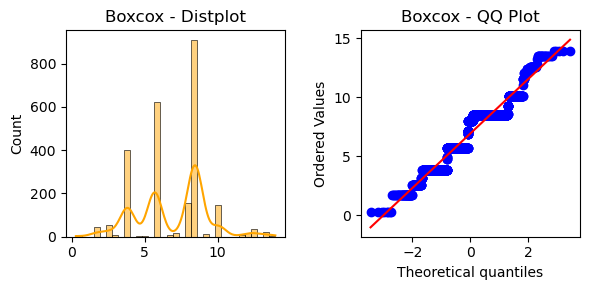

Log - rear_camera_mp
mu: 2.34, sigma: 0.43


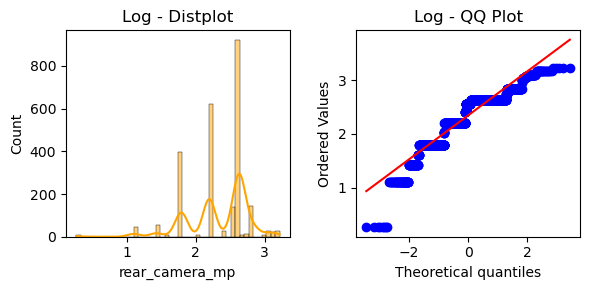

Reciprocal - rear_camera_mp
mu: 0.13, sigma: 0.20


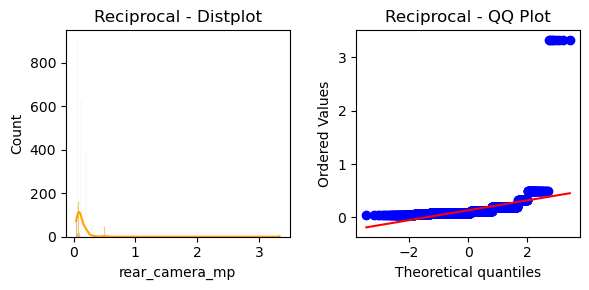

Sqroot - rear_camera_mp
mu: 3.14, sigma: 0.70


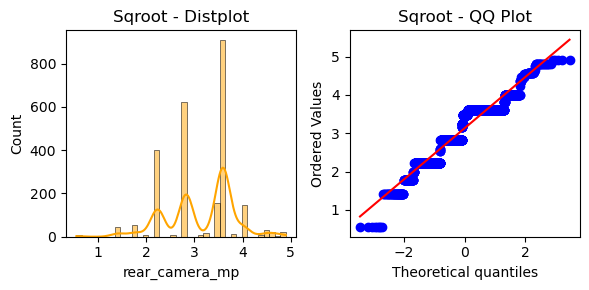

Exp - rear_camera_mp
mu: 6.90, sigma: 2.41


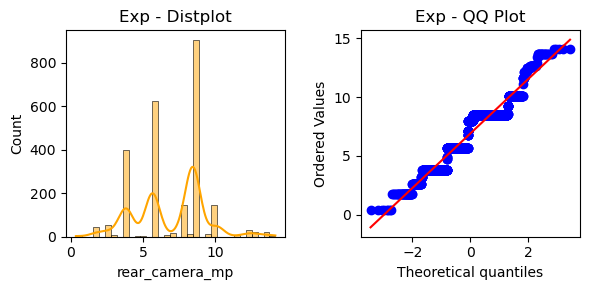

In [74]:
for x in transformations:
   try_transformation('rear_camera_mp',x)

Boxcox - front_camera_mp
mu: 1.96, sigma: 1.02


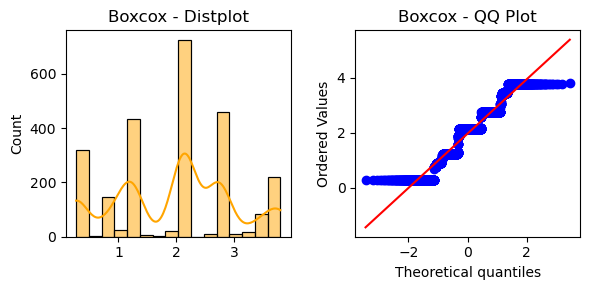

Log - front_camera_mp
mu: 1.61, sigma: 0.76


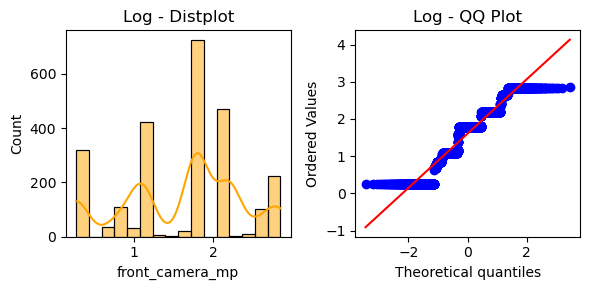

Reciprocal - front_camera_mp
mu: 0.67, sigma: 1.04


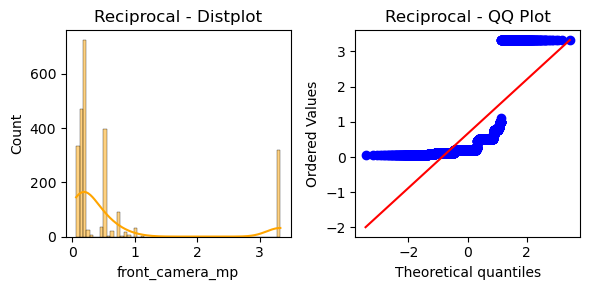

Sqroot - front_camera_mp
mu: 2.12, sigma: 0.99


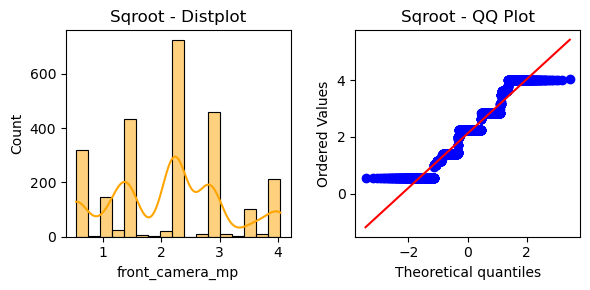

Exp - front_camera_mp
mu: 3.94, sigma: 2.78


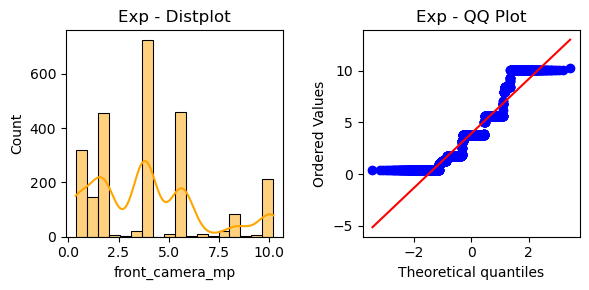

In [75]:
for x in transformations:
   try_transformation('front_camera_mp',x)

Boxcox - battery
mu: 19.86, sigma: 1.57


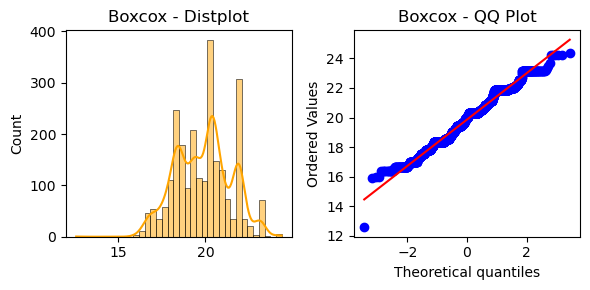

Log - battery
mu: 7.90, sigma: 0.31


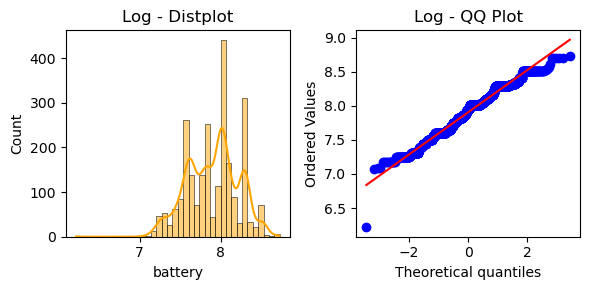

Reciprocal - battery
mu: 0.00, sigma: 0.00


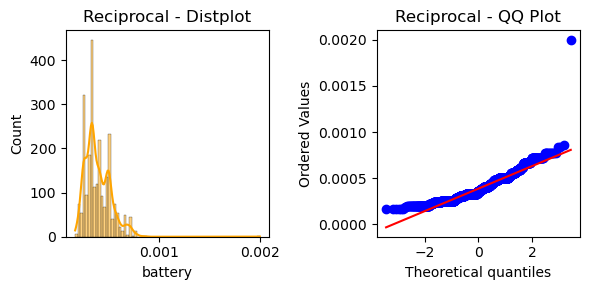

Sqroot - battery
mu: 52.66, sigma: 8.12


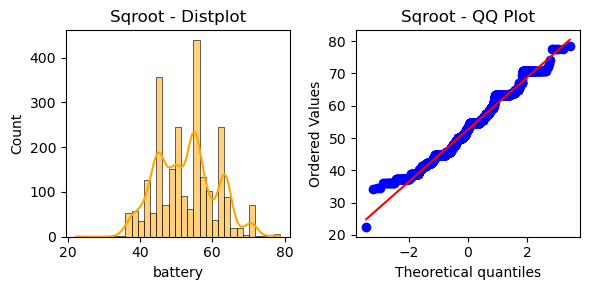

Exp - battery
mu: 749.62, sigma: 192.17


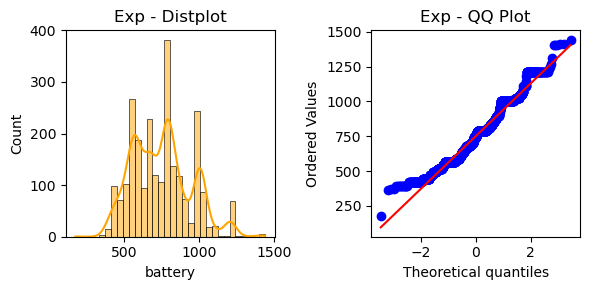

In [76]:
for x in transformations:
   try_transformation('battery',x)

Boxcox - weight
mu: 9.25, sigma: 0.47


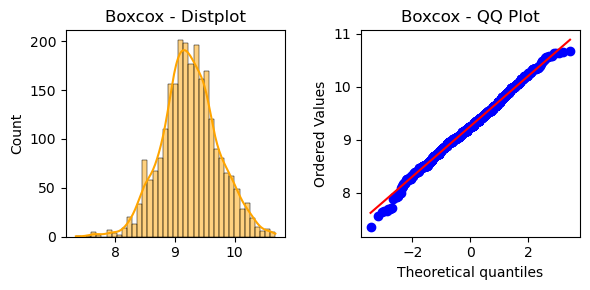

Log - weight
mu: 5.05, sigma: 0.16


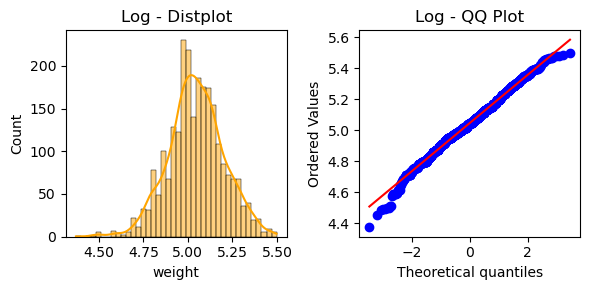

Reciprocal - weight
mu: 0.01, sigma: 0.00


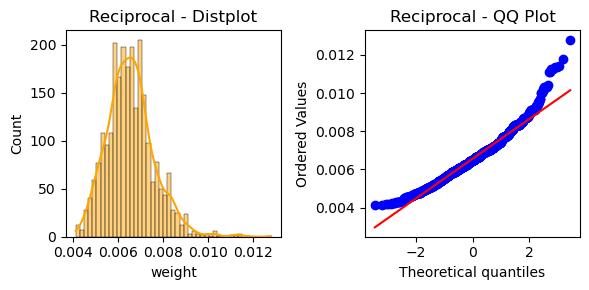

Sqroot - weight
mu: 12.46, sigma: 0.98


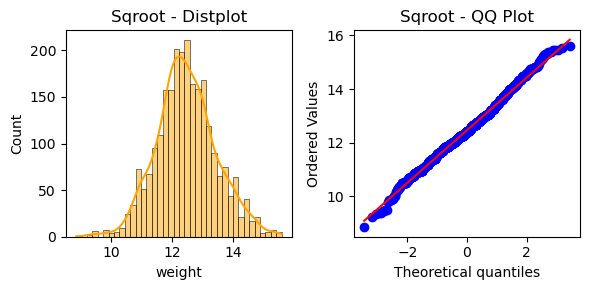

Exp - weight
mu: 67.23, sigma: 8.81


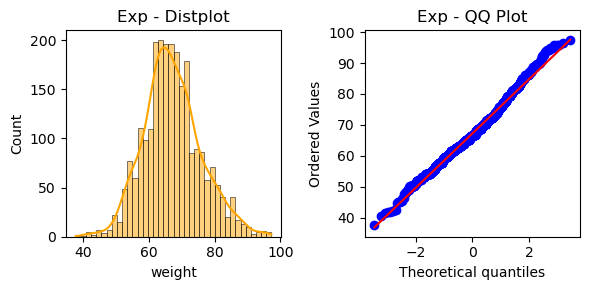

In [77]:
for x in transformations:
   try_transformation('weight',x)

Boxcox - days_used
mu: 5259.13, sigma: 2149.61


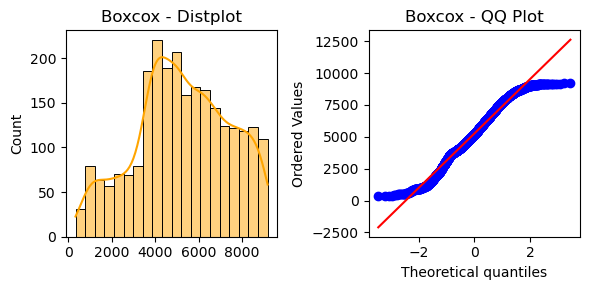

Log - days_used
mu: 6.49, sigma: 0.42


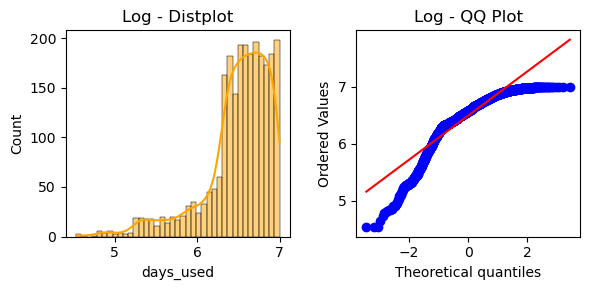

Reciprocal - days_used
mu: 0.00, sigma: 0.00


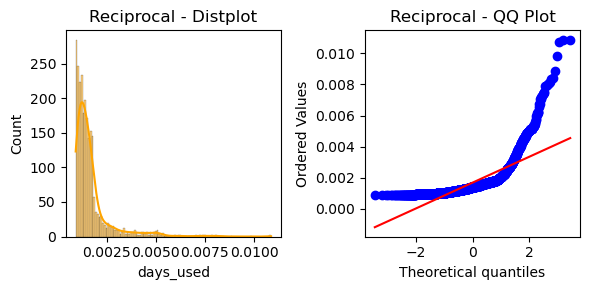

Sqroot - days_used
mu: 26.21, sigma: 4.73


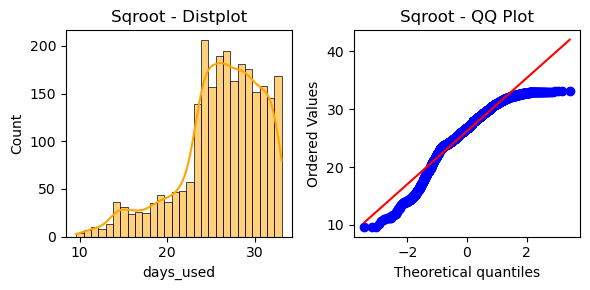

Exp - days_used
mu: 235.52, sigma: 65.55


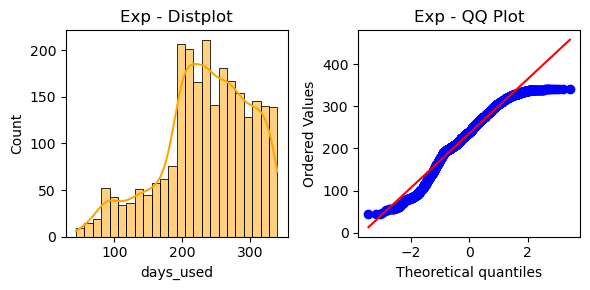

In [78]:
for x in transformations:
   try_transformation('days_used',x)

After correcting skewness for: SCREEN_SIZE
Mu: 2.5402, Sigma: 0.1266


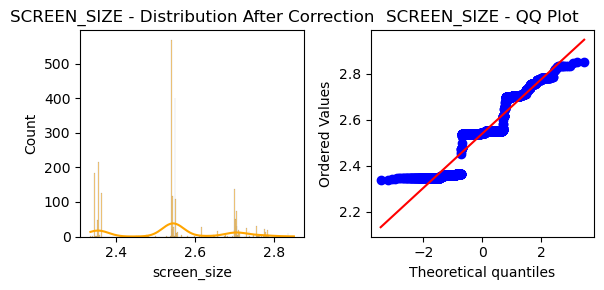

After correcting skewness for: REAR_CAMERA_MP
Mu: 3.1351, Sigma: 0.6982


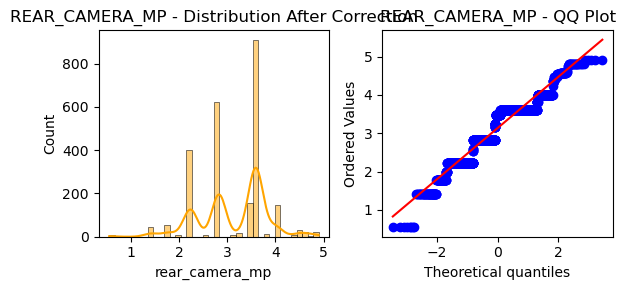

After correcting skewness for: FRONT_CAMERA_MP
Mu: 1.9640, Sigma: 1.0233


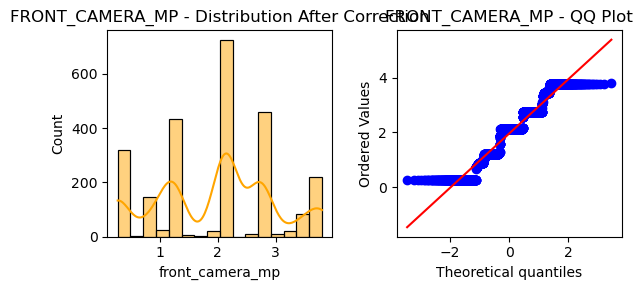

After correcting skewness for: BATTERY
Mu: 19.8625, Sigma: 1.5739


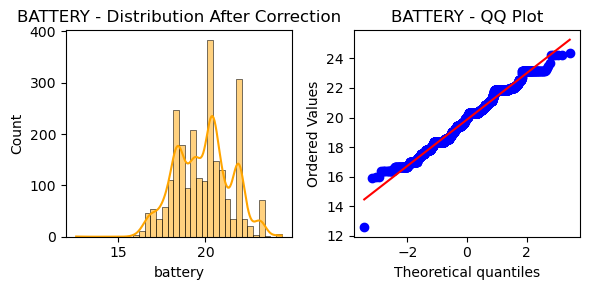

After correcting skewness for: WEIGHT
Mu: 0.0066, Sigma: 0.0011


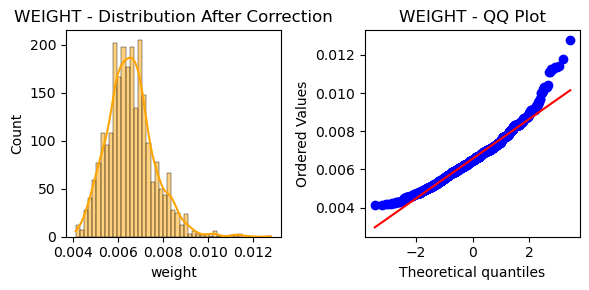

In [79]:
def skweness_correction(column):
    # Apply appropriate transformation based on the column name
    if column in ['front_camera_mp', 'screen_size', 'battery']:
        data[column], _ = boxcox(data[column] + 1)
    elif column == 'weight':
        data[column] = 1 / data[column].replace([np.inf, -np.inf], 0)
    elif column == 'rear_camera_mp':
        data[column] = np.sqrt(data[column])

    print(f"After correcting skewness for: {column.upper()}")
    
    # Fit normal distribution and visualize
    mu, sigma = norm.fit(data[column])
    print(f"Mu: {mu:.4f}, Sigma: {sigma:.4f}")

    plt.figure(figsize=(6, 3))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True, color="orange")
    plt.title(f"{column.upper()} - Distribution After Correction")

    plt.subplot(1, 2, 2)
    stats.probplot(data[column], dist="norm", plot=plt)
    plt.title(f"{column.upper()} - QQ Plot")

    plt.tight_layout()
    plt.show()

# List of skewed columns to correct
skewed_columns = ['screen_size', 'rear_camera_mp', 'front_camera_mp', 'battery', 'weight']

# Apply correction
for col in skewed_columns:
    skweness_correction(col)

In [80]:
data = data.drop(['os','device_brand'],axis=1)
data

,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,2.655981,1,0,3.605551,2.139908,64.0,3.0,20.372111,0.006849,2020,127,4.307572,4.715100
1,2.811569,1,1,3.605551,3.768684,128.0,8.0,22.271107,0.004695,2020,325,5.162097,5.519018
2,2.779854,1,1,3.605551,2.735501,128.0,8.0,22.140320,0.004695,2020,162,5.111084,5.884631
3,2.704345,1,0,3.605551,2.735501,64.0,3.0,23.124600,0.005405,2020,293,4.389995,4.947837
4,2.755189,1,0,3.605551,2.735501,64.0,4.0,21.871141,0.005682,2020,223,4.413889,5.060694
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,2.701468,1,0,2.828427,2.557667,64.0,4.0,20.524725,0.005155,2019,208,5.100902,6.287933
2476,2.699737,1,0,3.605551,2.735501,128.0,8.0,21.871141,0.005000,2018,541,5.037732,6.251538
2477,2.731515,1,0,3.605551,2.139908,32.0,3.0,21.871141,0.006061,2020,201,4.357350,4.528829
2478,2.731515,1,0,3.605551,2.139908,32.0,2.0,21.871141,0.006250,2020,149,4.349762,4.624188


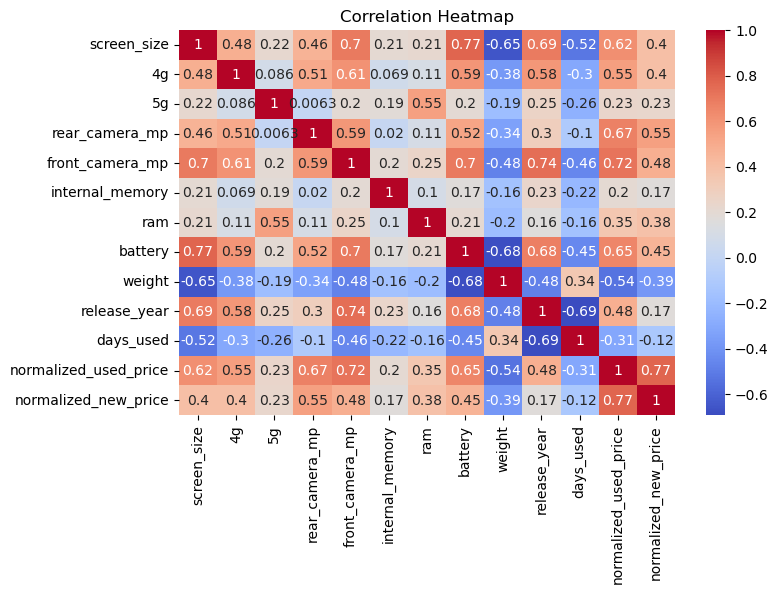

In [81]:
#Correlation using heat map
plt.figure(figsize=(8, 5))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [82]:
#Splitting the dataset into Train and Test data:
Y = data['normalized_used_price']
X = data.loc[:, data.columns != 'normalized_used_price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train.head()
X_train.columns

Index(['screen_size', '4g', '5g', 'rear_camera_mp', 'front_camera_mp',
       'internal_memory', 'ram', 'battery', 'weight', 'release_year',
       'days_used', 'normalized_new_price'],
      dtype='object')

In [83]:
#Scaling features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_test.shape[0]

744

In [84]:
#Machine Learning code
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)
X_train_Prediction = linear_model.predict(X_train)
print("MSE : ",mean_squared_error(y_train,X_train_Prediction))
print("R2 Score : ",r2_score(y_train,X_train_Prediction))
cross_linear=cross_val_score(linear_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)
mean_cross_linear = np.mean(cross_linear)
print(mean_cross_linear)

MSE :  0.04359285116754557
R2 Score :  0.7923765078788532
-0.04443812294492831


In [85]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train,y_train)
X_train_pred_lasso = lasso_model.predict(X_train)
print("MSE : ",mean_squared_error(y_train,X_train_pred_lasso))
print("R2 Score : ",r2_score(y_train,X_train_pred_lasso))

cross_lasso=cross_val_score(lasso_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)
mean_cross_lasso = np.mean(cross_lasso)
print(mean_cross_lasso)

MSE :  0.04386453729332627
R2 Score :  0.7910825245608395
-0.04453504657574901


In [86]:
ridge_model = Ridge()
ridge_model.fit(X_train,y_train)
X_train_pred_ridge = ridge_model.predict(X_train)
print("MSE : ",mean_squared_error(y_train,X_train_pred_ridge))
print("R2 Score : ",r2_score(y_train,X_train_pred_ridge))

cross_ridge=cross_val_score(ridge_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)
mean_cross_ridge = np.mean(cross_ridge)
print(mean_cross_ridge)

MSE :  0.04359287684525149
R2 Score :  0.7923763855813931
-0.04443630942748257


In [87]:
svmreg_model = SVR()
svmreg_model.fit(X_train,y_train)
X_train_pred_svmreg = svmreg_model.predict(X_train)
y_pred_svm = svmreg_model.predict(X_test)
print("Trained_score:")
print("MSE : ",mean_squared_error(y_train,X_train_pred_svmreg))
print("R2 Score : ",r2_score(y_train,X_train_pred_svmreg))
print("Test_score:")
print("MSE : ",mean_squared_error(y_test,y_pred_svm))
print("R2 Score : ",r2_score(y_test,y_pred_svm))
r2_svm = r2_score(y_test,y_pred_svm)

Trained_score:
MSE :  0.03548779823578515
R2 Score :  0.8309791536900009
Test_score:
MSE :  0.0514873284199109
R2 Score :  0.7729558761733509


In [88]:
dtree_model = DecisionTreeRegressor(max_depth=10)
dtree_model.fit(X_train,y_train)
X_train_pred_dtree = dtree_model.predict(X_train)
print("MSE : ",mean_squared_error(y_train,X_train_pred_dtree))
print("R2 Score : ",r2_score(y_train,X_train_pred_dtree))

cross_dtree=cross_val_score(dtree_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)
mean_cross_dtree = np.mean(cross_dtree)
print(mean_cross_dtree)

X_test_pred_dtree = dtree_model.predict(X_test)
print("MSE : ",mean_squared_error(y_test,X_test_pred_dtree))
print("R2 Score : ",r2_score(y_test,X_test_pred_dtree))

MSE :  0.012756578850425762
R2 Score :  0.939243124101596
-0.08071582119377992
MSE :  0.07284271462233032
R2 Score :  0.678784842287798


In [89]:
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train,y_train)
X_train_pred_rfr = rfr_model.predict(X_train)
print("MSE : ",mean_squared_error(y_train,X_train_pred_rfr))
print("R2 Score : ",r2_score(y_train,X_train_pred_rfr))

cross_rfr=cross_val_score(rfr_model,X_train,y_train,scoring="neg_mean_squared_error",cv=5)
mean_cross_rfr = np.mean(cross_rfr)
print(mean_cross_rfr)

X_test_pred_rfr = rfr_model.predict(X_test)
print("MSE : ",mean_squared_error(y_test,X_test_pred_rfr))
print("R2 Score : ",r2_score(y_test,X_test_pred_rfr))

MSE :  0.007029015675361224
R2 Score :  0.9665222911187035
-0.04895495859234293
MSE :  0.05016748249960826
R2 Score :  0.7787760123069906


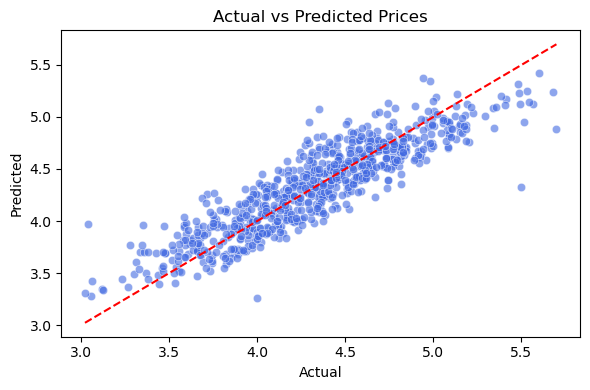

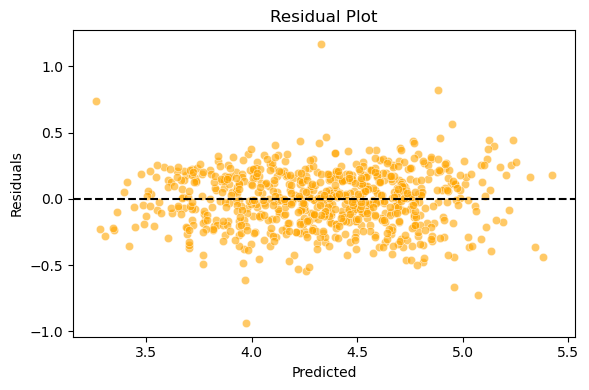

In [90]:
y_pred = linear_model.predict(X_test)  # or X_train if you want training residuals

# Residuals
residuals = y_test - y_pred

# Plot: Actual vs Predicted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Prices')
plt.tight_layout()
plt.show()

# Plot: Residuals
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals, color='orange', alpha=0.6)
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()